In [335]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import seaborn as sns
from scipy import stats
import networkx as nx
from tqdm import tqdm_notebook

import plotly.plotly as py
import plotly.graph_objs as go

%matplotlib inline

In [9]:
# Load MFCC features
mfcc_dict = {}

for filename in os.listdir('data/features/mfcc/'):
    id = int(filename.split('.')[0])
    mfcc_dict[id] = np.load('data/features/mfcc/' + filename)

In [10]:
# Load artist data
artists = pd.read_csv('data/allmusic/artists_cleaned.csv')

In [11]:
# Compute genre popularity
artists['main_genre'].value_counts()

Pop/Rock          7185
Jazz              1462
R&B;              1100
Unknown           1090
Rap                967
Electronic         965
Country            751
Latin              429
Blues              410
International      337
Vocal              313
Folk               305
Religious          274
Reggae             264
Classical          257
Comedy/Spoken      181
Avant-Garde        128
New Age            113
Stage & Screen     111
Easy Listening      47
Children's          14
Holiday              1
Name: main_genre, dtype: int64

In [12]:
# Top 7 most popular genres, removing 'Unknown'
top_genres = artists['main_genre'].value_counts()[:8].index.tolist()
top_genres.remove('Unknown')

In [13]:
# Filter for ids of artists with > 25 followers
ids_filtered = artists[(artists['main_genre'].isin(top_genres))]['id'].tolist()

In [14]:
# Create feature matrix
X = []
ids = []
# Create lists of artist name and main genre for visualization purposes
artist_names = []
main_genres = []

for id in ids_filtered:
    try:
        X.append(mfcc_dict[id].flatten())
        ids.append(id)
        main_genres.append(artists[artists['id'] == id]['main_genre'].tolist()[0])
        artist_names.append(artists[artists['id'] == id]['name'].tolist()[0])

    # we don't have audio for some ids, so pass
    except Exception as e:
        pass

X = np.array(X)

# PCA

In [281]:
pca = PCA(n_components=2)
pca.fit(X)
# Reduce dimensionality of X
X_reduced = pca.transform(X)

In [282]:
# Percentage of variance explained
pca.explained_variance_ratio_

array([ 0.472716  ,  0.07717337])

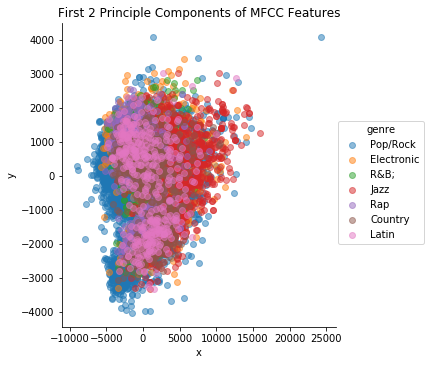

In [121]:
pca_df = pd.DataFrame(dict(x=X_reduced[:,0], y=X_reduced[:,1], genre=main_genres, name=artist_names))
sns.lmplot('x', 'y', data=pca_df, hue='genre', fit_reg=False, scatter_kws={'alpha':0.5})
plt.title('First 2 Principle Components of MFCC Features')

In [117]:
# Get indices of n most influential artists for each genre
most_inf_by_genre_indices = artists.groupby('main_genre')['outdegree']\
                            .nlargest(3)\
                            .index.levels[1].tolist()

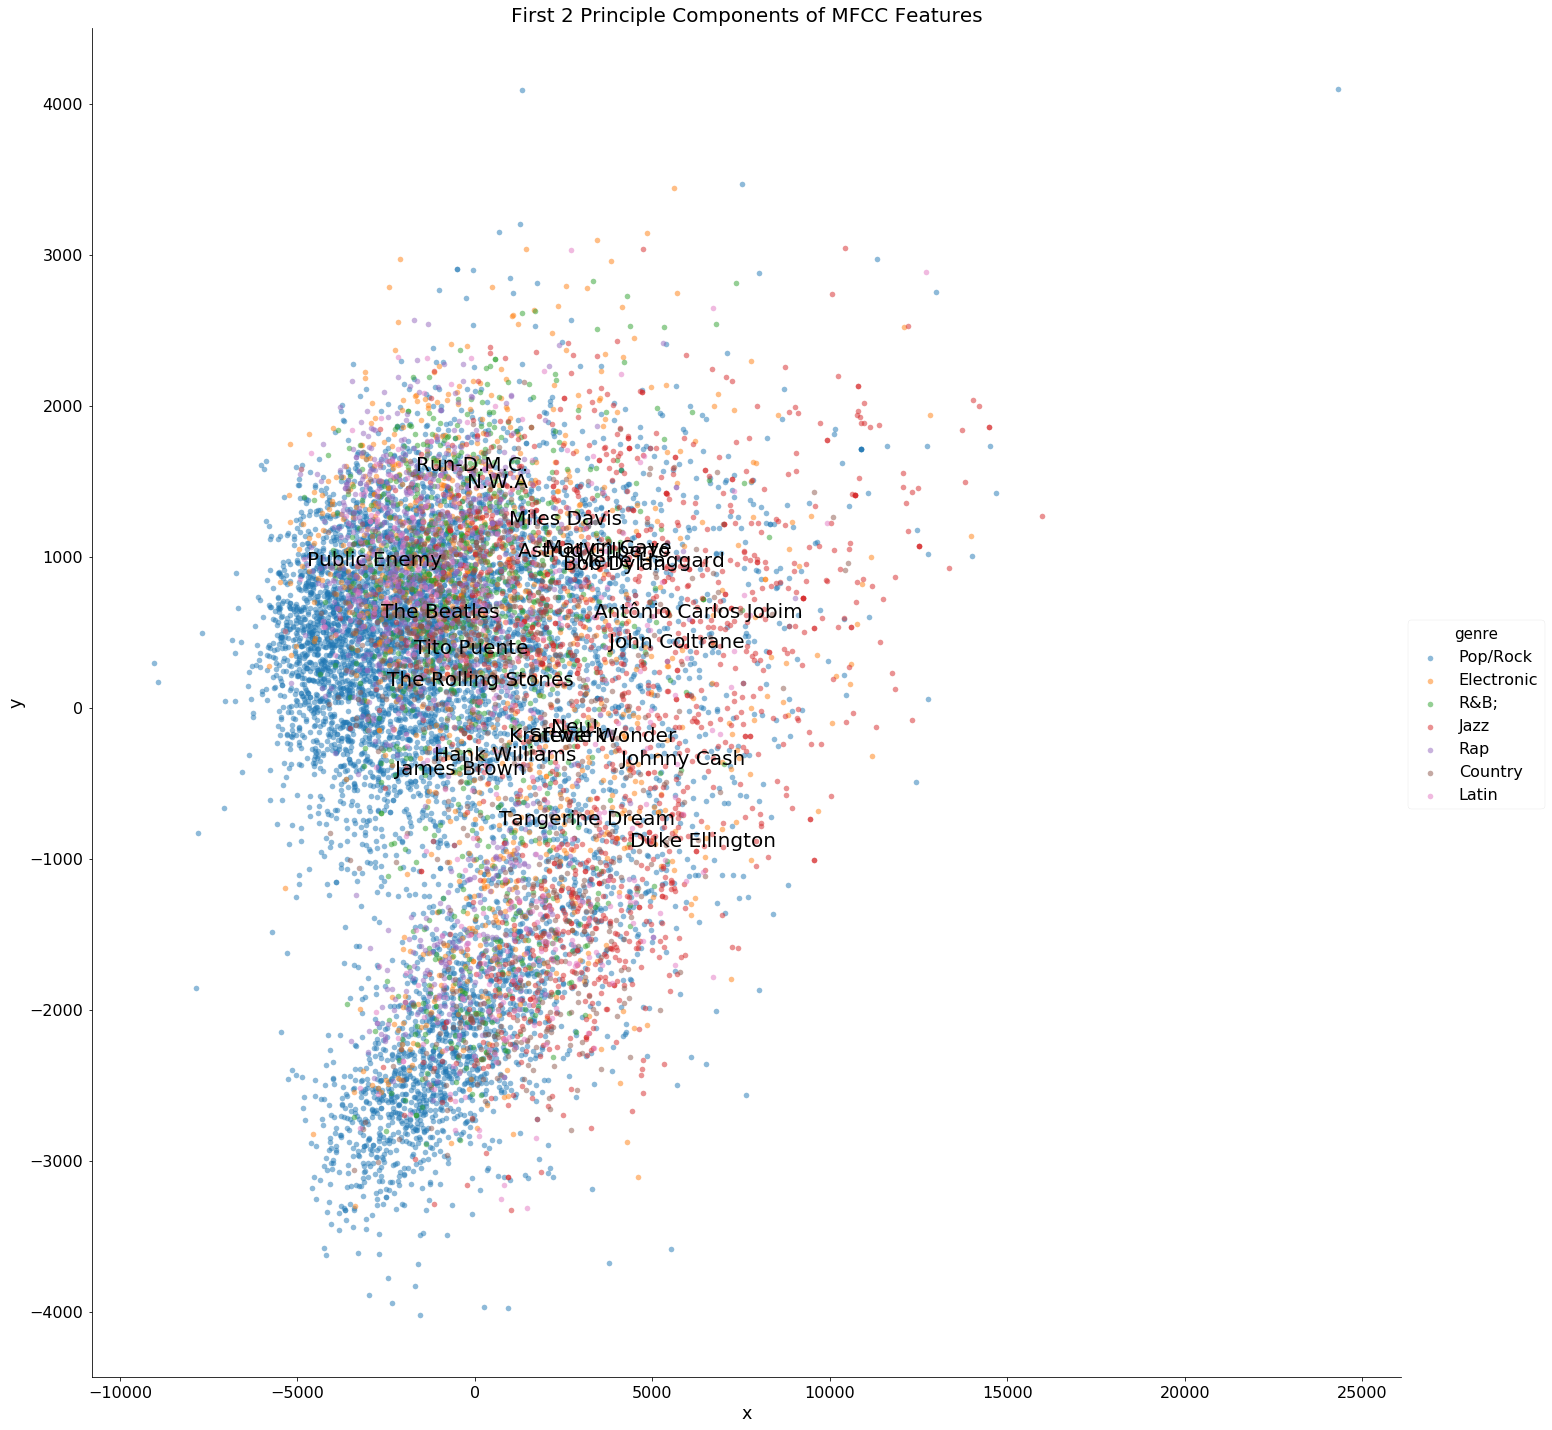

In [382]:
pca_df = pd.DataFrame(dict(x=X_reduced[:,0], y=X_reduced[:,1], genre=main_genres, name=artist_names))
with sns.plotting_context("paper", font_scale=2):
    sns.lmplot('x', 'y', data=pca_df, hue='genre', fit_reg=False, scatter_kws={'alpha':0.5}, size=20)
plt.title('First 2 Principle Components of MFCC Features', size=20)

# Add labels for artists who are among most influential for their genre
for i, txt in enumerate(artist_names):
    if artists[artists['id'] == ids[i]]['id'].index[0] in most_inf_by_genre_indices:
        plt.annotate(txt.decode('utf-8'), (X_reduced[:,0][i],X_reduced[:,1][i]), size=20)

In [148]:
# trace1 = go.Scattergl(
#     x = X_reduced[:,0],
#     y = X_reduced[:,1],
#     mode='markers+text',
#     marker=dict(
#         size='16',
#     ),
#     text=artist_names,
# )
# data = [trace1]

# py.iplot(data, filename='scatter-plot-with-colorscale')

# Average Distance To Influencers By Depth of BFS

In [155]:
# Load allmusic influence graph
influence_graph = nx.read_multiline_adjlist('networks/allmusic_influence_graph.txt', nodetype=int, create_using=nx.DiGraph())

In [283]:
# Compute pairwise distance matrix
dist_matrix = cdist(X_reduced, X_reduced)

In [284]:
dist_dict = {}

for i, u in enumerate(tqdm_notebook(ids)):
    dist_dict[u] = {}    
    for j, v in enumerate(ids):
        dist_dict[u][v] = dist_matrix[i][j]

A Jupyter Widget

In [350]:
def mean_distance_at_k(k, influence_graph=influence_graph, ids=ids, dist_dict=dist_dict):
    '''
    Calculate the mean distance in the PCA projection between every node 
    and each descendant at exactly depth k away in the influence_graph as found by BFS
    
    Args:
        k : depth to cut off BFS at
        influence_graph : networkX DiGraph of artist relationships
        ids : list of ids we have audio for
        dist_dict : dist_dict[u][v] returns Euclidean distance between nodes u and v in the PCA projection
        
    Returns:
        distances, mean distance tuple
    '''
    
    distances = []
    
    for u in ids:
        explored = set([u])
        last_fringe = [u]
        
        # Recursively explore successors until depth k is reached in BFS
        for i in range(k):
            current_fringe = set()
            
            for node in last_fringe:
                successors = influence_graph.successors(node)
                
            for successor in successors:
                if successor not in explored:
                    current_fringe.add(successor)
            
            last_fringe = current_fringe
            explored.update(last_fringe)

        for v in ids:
            if v in current_fringe:
                distances.append(dist_dict[u][v])
            
    return distances, np.mean(distances)

In [351]:
ks = range(1,10)
distances_list = []
mean_distances = []

for k in tqdm_notebook(ks):
    distances, mean = mean_distance_at_k(k)
    distances_list.append(distances)
    mean_distances.append(mean)

A Jupyter Widget

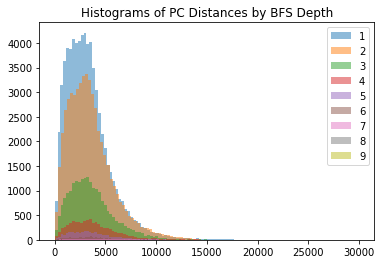

In [352]:
plt.title('Histograms of PC Distances by BFS Depth')
for i, distances in enumerate(distances_list):
    plt.hist(distances, bins=100, alpha=0.5, label=str(i+1))
plt.legend()

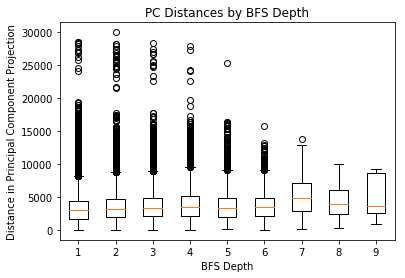

In [353]:
plt.title('PC Distances by BFS Depth')
plt.boxplot(distances_list)
plt.xlabel('BFS Depth')
plt.ylabel('Distance in Principal Component Projection')
plt.show()

In [354]:
# Nonparametric Kruskal-Wallis H-test for equality of population medians
stats.kruskal(*distances_list)

KruskalResult(statistic=1377.5893631613928, pvalue=3.965351042639036e-292)

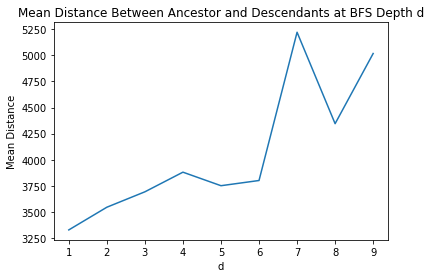

In [355]:
plt.plot(ks, mean_distances)
plt.title('Mean Distance Between Ancestor and Descendants at BFS Depth d')
plt.xlabel('d')
plt.ylabel('Mean Distance')

# Correlation Between Influence Graph Distance and PC Euclidean Distance

In [387]:
# Compute all pairs shortest paths dictionary
graph_dist_dict = nx.shortest_path_length(influence_graph.to_undirected())

In [388]:
euclidean_distances = []
graph_distances = []
no_path_counter = 0

for u in tqdm_notebook(dist_dict.keys()):
    for v in dist_dict[u].keys():
        if u != v:
            try:
                graph_distances.append(graph_dist_dict[u][v])
                euclidean_distances.append(dist_dict[u][v])
            except:
                no_path_counter += 1

print "Correlation between PC Euclidean Distance and Influence Graph Distance:", stats.pearsonr(euclidean_distances, graph_distances)
print "Number of no paths found:", no_path_counter
print "Number of paths found:", len(euclidean_distances)

A Jupyter Widget


Correlation between PC Euclidean Distance and Influence Graph Distance: (0.064977433583561228, 0.0)
Number of no paths found: 0
Number of paths found: 148462040


# KMeans on PCA Components

In [18]:
kmeans = KMeans(n_clusters=7)
cluster_assignments = kmeans.fit_predict(X_reduced)

In [225]:
print mean_distance_at_k(2)

3542.26375585


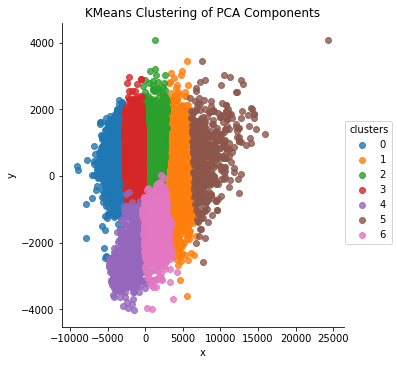

In [19]:
kmeans_df = pd.DataFrame(dict(x=X_reduced[:,0], y=X_reduced[:,1], clusters=cluster_assignments, name=artist_names))
sns.lmplot('x', 'y', data=kmeans_df, hue='clusters', fit_reg=False)
plt.title('KMeans Clustering of PCA Components')

In [230]:
print mean_distance_at_k(3)

3695.55297587


In [99]:
# # For each cluster, compute the majority genre per cluster
# for i in range(7):
#     # Get indices of artists belonging to that cluster
#     member_indices = np.argwhere(cluster_assignments == i).flatten()
#     # Get list of genres corresponding to those indices
#     genres_per_cluster = [main_genres[index] for index in member_indices]
#     print "Cluster {}:".format(i)
#     print pd.Series(genres_per_cluster).value_counts()
#     print 

# Plot Most Popular Influencer Per Genre and Immediate Followers

In [20]:
# Get series of indices of most popular artist by genre
influencers_by_genre = artists.groupby('main_genre')['outdegree'].idxmax()

In [25]:
# List the influencer for each artist if the influencer is among the top influencers, otherwise None
influencers = []

# Iterate through ids
for id in tqdm_notebook(ids):
    current_artist_genre = artists[artists['id'] == id]['main_genre'].tolist()[0]
    
    influencer_found = False
    
    for genre, top_influencer_idx in influencers_by_genre.iteritems():
        if genre in top_genres:
            top_influencer_id = artists.iloc[top_influencer_idx]['id']
            top_influencer_genre = artists.iloc[top_influencer_idx]['main_genre']

#             if (influence_graph.has_edge(top_influencer_id, id) or top_influencer_id == id) and (not influencer_found) and (current_artist_genre == top_influencer_genre):
            if (influence_graph.has_edge(top_influencer_id, id) or top_influencer_id == id) and (not influencer_found):
                influencers.append(artists.iloc[top_influencer_idx]['name'].decode('utf-8'))
                influencer_found = True
    
    if not influencer_found:
        influencers.append(None)

A Jupyter Widget

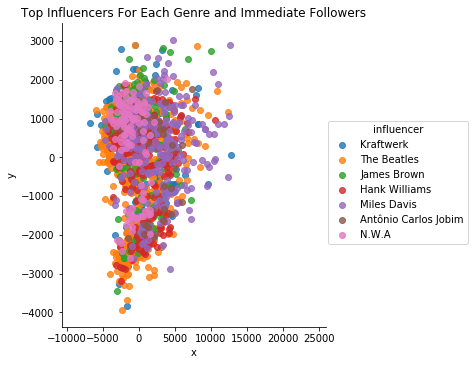

In [49]:
top_influencers_df = pd.DataFrame(dict(x=X_reduced[:,0], y=X_reduced[:,1], influencer=influencers, name=artist_names))
sns.lmplot('x', 'y', data=top_influencers_df, hue='influencer', fit_reg=False)
plt.title('Top Influencers For Each Genre and Immediate Followers')

In [81]:
# Create Facet plot so that the different influencer-follower groups can be seen more clearly
# g = sns.FacetGrid(data=top_influencers_df, row='influencer')
# g = g.map(plt.scatter, 'x', 'y')

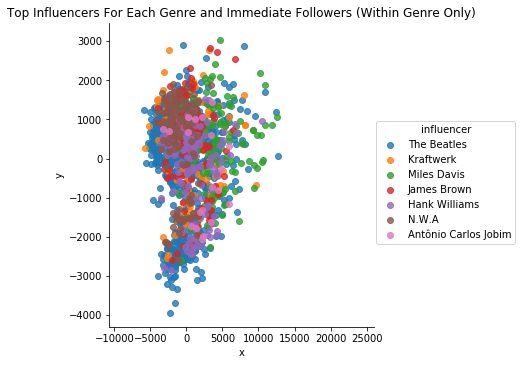

In [24]:
top_influencers_df = pd.DataFrame(dict(x=X_reduced[:,0], y=X_reduced[:,1], influencer=influencers, name=artist_names))
sns.lmplot('x', 'y', data=top_influencers_df, hue='influencer', fit_reg=False)
plt.title('Top Influencers For Each Genre and Immediate Followers (Within Genre Only)')

# TSNE

In [330]:
tsne = TSNE()
X_embedded = tsne.fit_transform(X[:1000])

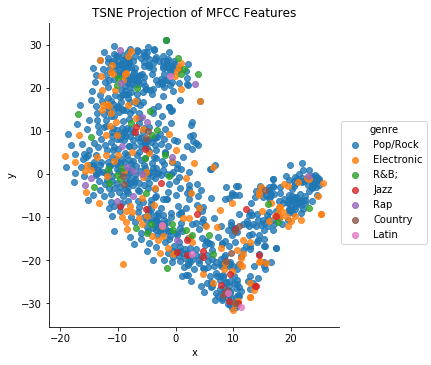

In [332]:
tsne_df = pd.DataFrame(dict(x=X_embedded[:,0], y=X_embedded[:,1], genre=main_genres[:1000], name=artist_names[:1000]))
sns.lmplot('x', 'y', data=tsne_df, hue='genre', fit_reg=False)
plt.title('TSNE Projection of MFCC Features')

It looks like TSNE projection doesn't seem to yield very good separation between genres.